In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

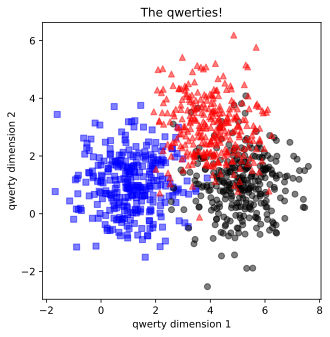

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [7]:
train_x, test_x, train_y, test_y = train_test_split(data, labels, train_size=0.9)

train_data = TensorDataset(train_x, train_y)
test_data = TensorDataset(test_x, test_y)

train_dl = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_dl = DataLoader(test_data, batch_size=test_data.__len__())

In [28]:
class model(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(2,8)
        self.hidden = nn.Linear(8,8)
        self.output = nn.Linear(8,3)

    def forward(self, data):
        x = F.relu(self.input(data))
        x = F.relu(self.hidden(x))
        x = self.output(x)

        return x


In [29]:
def getModel(optimizerType='Adam', lr=0.001, l2=0):
    ANN = model()

    lossFunction = nn.CrossEntropyLoss()
    optimFun = getattr(torch.optim, optimizerType)
    optimizer = optimFun(params=ANN.parameters(), lr=lr, weight_decay=l2)

    return ANN, lossFunction, optimizer

In [30]:
epochs = 50

def trainModel(ANN, lossFunction, optimizer):
    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []
    for _ in range(epochs):
        ANN.train()
        batchAcc = []
        batchLoss = []
        for x, y in train_dl:
            yHat = ANN.forward(x)

            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)
        ANN.eval()
        X, Y = next(iter(test_dl))
        with torch.no_grad():
            pred = ANN(X)
        
        testAcc.append(torch.mean((torch.argmax(pred, axis=1)==Y).float())*100)

    return trainAcc, testAcc, losses, ANN

In [31]:
l2 = np.linspace(0, 0.1, 6)

finalTrainAcc = np.zeros((epochs, len(l2)))
finalTestAcc = np.zeros((epochs, len(l2)))

for l2i in range(len(l2)):
    print("l2: ", l2[l2i])
    ANN, lossFunction, optimizer = getModel('Adam', 0.001, l2[l2i])
    trainAcc, testAcc, losses, ANN = trainModel(ANN, lossFunction, optimizer)
    finalTrainAcc[:, l2i] = trainAcc
    finalTestAcc[:, l2i] = testAcc

l2:  0.0
l2:  0.02
l2:  0.04
l2:  0.06
l2:  0.08
l2:  0.1


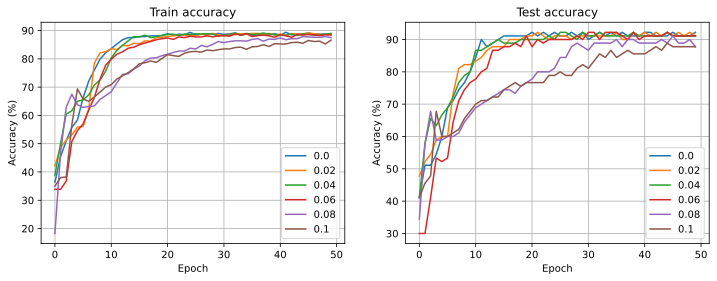

In [32]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

ax[0].plot(finalTrainAcc)
ax[0].set_title('Train accuracy')
ax[1].plot(finalTestAcc)
ax[1].set_title('Test accuracy')
for i in range(2):
    ax[i].legend(l2)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].grid()
plt.show()
